<a href="https://colab.research.google.com/github/doumoh/RIS_aided_communication/blob/main/Test_RIS_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 40

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

from sionna import PI
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera

In [3]:
# Load an empty scene and configure single linearly polarized antennas for
# all transmitters and receivers
scene = load_scene()
scene.frequency = 5.8e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")

# Place a transmitter far away from the RIS so that
# the incoming wave is almost planar
tx = Transmitter("tx", [-2.5,3,1.5])
rx = Receiver("rx", [3,0,3])
scene.add(tx)
scene.add(rx)

# Configure RIS in the x-z plane centered at the origin
width = 8 * scene.wavelength # Width [m] as described in [1]
num_rows = num_cols = int(width/(0.5*scene.wavelength))
ris = RIS(name="ris",
          position=[0.5,0,1.5],
          orientation=[0,-PI/2,0],
          num_rows=num_rows,
          num_cols=num_cols)
scene.add(ris)

In [12]:

reshaped_positions = tf.reshape(ris.cell_world_positions, (16, 16, 3))


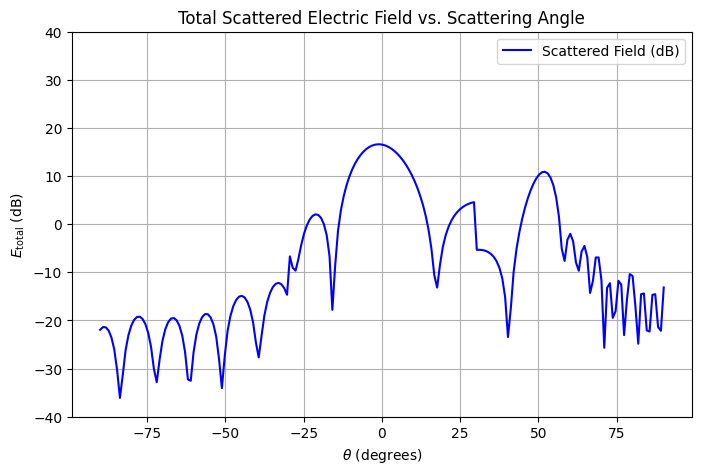

In [26]:
import numpy as np
import matplotlib.pyplot as plt

class RISModel:
    def __init__(self, M=16, N=16, wavelength=0.05172, tx_pos=[-5, 0, 5]):
        self.M = M  # Number of unit cells along x-axis
        self.N = N  # Number of unit cells along y-axis
        self.k = 2 * np.pi / wavelength  # Wavenumber
        self.tx_pos = np.array(tx_pos)  # Transmitter position
        self.eta0 = 120 * np.pi  # Free-space impedance
        self.Pt = 1  # Transmit power
        self.Gt = 100  # Transmit antenna gain


        # Initialize phi_sigma_eff as a zero matrix of size (M, N)
        self.phi_sigma_eff = np.zeros((M, N))

        # np.deg2rad(300) for switch OFF
        # np.deg2rad(0) for switch ON

        #self.phi_sigma_eff[:, 1:3] = np.deg2rad(300)
        #self.phi_sigma_eff[:, 6:8] = np.deg2rad(300)
        #self.phi_sigma_eff[:, 11:13] = np.deg2rad(300)
        #self.phi_sigma_eff[:, 6:11] = np.deg2rad(330)
        self.phi_sigma_eff[:, 5:11] = np.deg2rad(330)


    def calculate_sigma_eff(self, theta_sc):
        """ Just conditions for precise results """
        if -30 <= theta_sc <= 30:  # Use theta_sc directly instead of self.theta_sc
            sigma_eff_dB = -32
        else:
            sigma_eff_dB = -42
        return 10**(sigma_eff_dB / 10)  # Convert to linear scale


    @staticmethod
    def calculate_distance(point1, point2):
        """Compute Euclidean distance between two 3D points."""
        return np.linalg.norm(np.array(point1) - np.array(point2))


    def compute_total_scattered_field(self, rx_pos,theta_sc):
        E_total = 0
        for m in range(self.M):
            for n in range(self.N):
                Rt_mn = self.calculate_distance(self.tx_pos, reshaped_positions[m, n]) # Distance between Transmitter and the unit cell
                Rr_mn = self.calculate_distance(rx_pos, reshaped_positions[m, n]) # Distance between Reciever and the unit cell
                # Calculate E for each unit cell
                E_sc_mn = (
                    np.sqrt(2 * self.eta0 * self.Pt * self.Gt) / (4 * np.pi)
                    * np.sqrt(np.exp(1j * self.phi_sigma_eff[m, n]) * self.calculate_sigma_eff(theta_sc))
                    * np.exp(-1j * self.k * (Rt_mn + Rr_mn))
                    / (Rt_mn * Rr_mn)

                )
                E_total += E_sc_mn
        return np.abs(E_total)

    def plot_scattered_field(self, r_distance=3, theta_range=(-90, 90), num_points=200):

     theta_vals = np.linspace(theta_range[0], theta_range[1], num_points)
     E_vals = []

     for theta_rad in np.radians(theta_vals):  # Convert to radians for calculations
        theta_deg = np.degrees(theta_rad)  # Convert back to degrees for sigma_eff condition
        rx_pos = (r_distance * np.cos(theta_rad), 0, r_distance * np.sin(theta_rad)) #Keep changing position of the reciever for scanning E field in cartesian coordinates
        E_vals.append(self.compute_total_scattered_field(rx_pos, theta_deg))  # Pass theta in degrees

    #convert to dB scale
     E_vals_dB = 20 * np.log10(E_vals)

     plt.figure(figsize=(8, 5))
     plt.plot(theta_vals, E_vals_dB, color="blue", label="Scattered Field (dB)")
     plt.xlabel(r"$\theta$ (degrees)")
     plt.ylabel(r"$E_{\text{total}}$ (dB)")
     plt.title("Total Scattered Electric Field vs. Scattering Angle")
     plt.legend()
     plt.grid()
     plt.ylim([-40, 40])
     plt.show()

     return E_vals


# Example usage
ris_model = RISModel()
e=ris_model.plot_scattered_field()


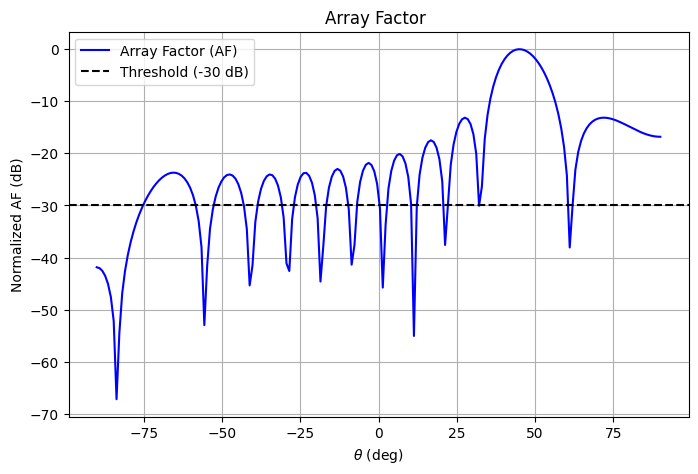

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define Parameters
M, N = 16, 16  # RIS size (M x N elements)
d = 0.019 # Element spacing in wavelengths
k = 2 * np.pi/0.0517  # Wavenumber

# Incident Wave Angles
theta_inc = np.radians(45)  # Incident elevation angle
phi_inc = np.radians(180)      # Incident azimuth angle

# Scattering Angles (Theta_s from -90° to 90°)
theta_sc = np.radians(np.linspace(-90, 90, 200))  # Convert to radians
phi_sc = 0  # Azimuth angle is fixed (phi = 0°)

# Compute Phase Terms (psi_x and psi_y)
psi_x = k * d * (np.sin(theta_inc) * np.cos(phi_inc) + np.sin(theta_sc) * np.cos(phi_sc))
psi_y = k * d * (np.sin(theta_inc) * np.sin(phi_inc) + np.sin(theta_sc) * np.sin(phi_sc))

# Compute Array Factor (AF) using the given formula
AF_x = np.sinc(M * psi_x / (2 * np.pi)) / np.sinc(psi_x / (2 * np.pi))
AF_y = np.sinc(N * psi_y / (2 * np.pi)) / np.sinc(psi_y / (2 * np.pi))
AF = np.abs(AF_x * AF_y)  # Take absolute value

# Convert to dB scale
AF_dB = 20 * np.log10(AF / np.max(AF))  # Normalize to 0 dB max

# Plot AF vs. Scattering Angle Theta
plt.figure(figsize=(8, 5))
plt.plot(np.degrees(theta_sc), AF_dB, label="Array Factor (AF)", color="blue")
plt.axhline(y=-30, color="black", linestyle="dashed", label="Threshold (-30 dB)")
plt.xlabel(r"$\theta$ (deg)")
plt.ylabel("Normalized AF (dB)")
plt.title("Array Factor ")
plt.legend()
plt.grid()
plt.show()
